
*   How to Build an Image Classifier with Keras </br>
https://www.section.io/engineering-education/image-classifier-keras/



*   Image Classification Using VGG - Cat or Dog Kaggle Competition </br> 
https://github.com/patrick013/Image-Classification-CNN-and-VGG/blob/master/Dog_vs_Cat.ipynb



*   How to Use The Pre-Trained VGG Model to Classify Objects in Photographs <br>
https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/

*   How to predict an image using CNN with Keras? </br>
https://towardsdatascience.com/how-to-predict-an-image-with-keras-ca97d9cd4817

In [1]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### (Zipped) Dataset upload using Drive
https://towardsdatascience.com/how-to-successfully-add-large-data-sets-to-google-drive-130beb320f1a



*   Create a shortcut in MyDrive from Sharedwithme folder in Google Drive



In [2]:
!unzip gdrive/My\ Drive/315_Birds_Species.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/VARIED THRUSH/029.jpg  
  inflating: train/VARIED THRUSH/030.jpg  
  inflating: train/VARIED THRUSH/031.jpg  
  inflating: train/VARIED THRUSH/032.jpg  
  inflating: train/VARIED THRUSH/033.jpg  
  inflating: train/VARIED THRUSH/034.jpg  
  inflating: train/VARIED THRUSH/035.jpg  
  inflating: train/VARIED THRUSH/036.jpg  
  inflating: train/VARIED THRUSH/037.jpg  
  inflating: train/VARIED THRUSH/038.jpg  
  inflating: train/VARIED THRUSH/039.jpg  
  inflating: train/VARIED THRUSH/040.jpg  
  inflating: train/VARIED THRUSH/041.jpg  
  inflating: train/VARIED THRUSH/042.jpg  
  inflating: train/VARIED THRUSH/043.jpg  
  inflating: train/VARIED THRUSH/044.jpg  
  inflating: train/VARIED THRUSH/045.jpg  
  inflating: train/VARIED THRUSH/046.jpg  
  inflating: train/VARIED THRUSH/047.jpg  
  inflating: train/VARIED THRUSH/048.jpg  
  inflating: train/VARIED THRUSH/049.jpg  
  inflating: train/VARIED THRUSH/050.jpg  
  i

In [ ]:
!unzip gdrive/My\ Drive/315_Birds_Species.zip > /dev/null

replace test/AFRICAN CROWNED CRANE/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Binary Image Classification using VGG16 and Custom Model


1.   Data Augmentation
2.   Transfer Learning
3.   Grad-CAM





Import Libraries

In [3]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
import os, random
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


# DATA AUGMENTATION
ZOOM, ROTATE, HORIZONTAL FLIP, BRIGHTNESS

In [4]:
# Data Preprocessing and Augmentation
# Generate training, testing and validation batches
dgen_train = ImageDataGenerator(rescale=1./255,
                                validation_split=0.2,  # using 20% of training data for validation 
                                zoom_range=0.2,
                                rotation_range=15,
                                horizontal_flip=True,
                                brightness_range=[0.1, 2])
dgen_validation = ImageDataGenerator(rescale=1./255)
dgen_test = ImageDataGenerator(rescale=1./255)


In [5]:
TARGET_SIZE = (150, 150)
BATCH_SIZE = 32
CLASS_MODE = 'categorical'  # for two classes; categorical for over 2 classes

# Connecting the ImageDataGenerator objects to our dataset
train_generator = dgen_train.flow_from_directory('/content/train/',
                                                 target_size=TARGET_SIZE,
                                                 subset='training',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=CLASS_MODE)
print(train_generator)
validation_generator = dgen_train.flow_from_directory('/content/valid/',
                                                      target_size=TARGET_SIZE,
                                                      subset='validation',
                                                      batch_size=BATCH_SIZE,
                                                      class_mode=CLASS_MODE)
test_generator = dgen_test.flow_from_directory('/content/test/',
                                               target_size=TARGET_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode=CLASS_MODE)

Found 36890 images belonging to 315 classes.
Found 315 images belonging to 315 classes.
Found 1575 images belonging to 315 classes.


In [6]:
train_generator.class_indices

{'AFRICAN CROWNED CRANE': 0,
 'AFRICAN FIREFINCH': 1,
 'ALBATROSS': 2,
 'ALEXANDRINE PARAKEET': 3,
 'AMERICAN AVOCET': 4,
 'AMERICAN BITTERN': 5,
 'AMERICAN COOT': 6,
 'AMERICAN GOLDFINCH': 7,
 'AMERICAN KESTREL': 8,
 'AMERICAN PIPIT': 9,
 'AMERICAN REDSTART': 10,
 'ANHINGA': 11,
 'ANNAS HUMMINGBIRD': 12,
 'ANTBIRD': 13,
 'ARARIPE MANAKIN': 14,
 'ASIAN CRESTED IBIS': 15,
 'BALD EAGLE': 16,
 'BALD IBIS': 17,
 'BALI STARLING': 18,
 'BALTIMORE ORIOLE': 19,
 'BANANAQUIT': 20,
 'BANDED BROADBILL': 21,
 'BANDED PITA': 22,
 'BAR-TAILED GODWIT': 23,
 'BARN OWL': 24,
 'BARN SWALLOW': 25,
 'BARRED PUFFBIRD': 26,
 'BAY-BREASTED WARBLER': 27,
 'BEARDED BARBET': 28,
 'BEARDED BELLBIRD': 29,
 'BEARDED REEDLING': 30,
 'BELTED KINGFISHER': 31,
 'BIRD OF PARADISE': 32,
 'BLACK & YELLOW bROADBILL': 33,
 'BLACK BAZA': 34,
 'BLACK FRANCOLIN': 35,
 'BLACK SKIMMER': 36,
 'BLACK SWAN': 37,
 'BLACK TAIL CRAKE': 38,
 'BLACK THROATED BUSHTIT': 39,
 'BLACK THROATED WARBLER': 40,
 'BLACK VULTURE': 41,
 'BLACK-CAP

In [7]:
train_generator.image_shape

(150, 150, 3)

# VGG16

In [ ]:
model = VGG16(include_top=False, input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(315, activation='softmax')(class1) # add softmax layer

In [ ]:
print(output.shape)

(1, 315)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

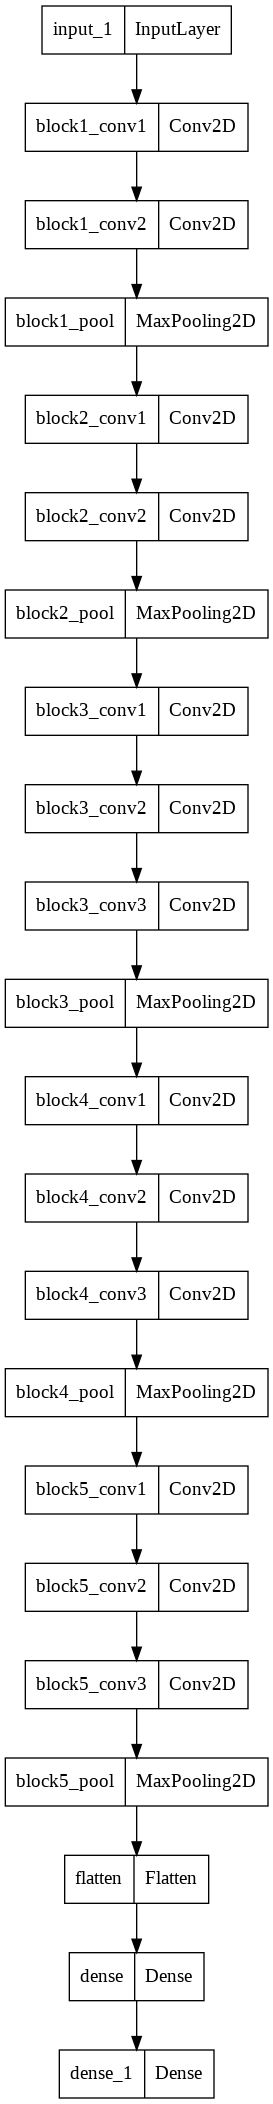

In [ ]:
model = Model(inputs=model.inputs, outputs=output)
model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='Vgg16_model.png')

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### Training VGG16 Model
**Epochs: 10 ,  Batch size: 64,  Learning Rate: 0.001,  Optimizer: ADAM**

In [ ]:

sgd = tf.keras.optimizers.SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              metrics=['accuracy'])
import time
start_time = time.time()
history_VGG1 = model.fit(train_generator, batch_size=64,
              epochs=5, 
              validation_data=validation_generator)
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/5
1153/1153 [==============================] - 479s 414ms/step - loss: 9.7387 - accuracy: 0.0033 - val_loss: 10.2849 - val_accuracy: 0.0032
Epoch 2/5
1153/1153 [==============================] - 477s 414ms/step - loss: 9.2186 - accuracy: 0.0031 - val_loss: 10.2849 - val_accuracy: 0.0032
Epoch 3/5
1153/1153 [==============================] - 477s 413ms/step - loss: 9.2750 - accuracy: 0.0031 - val_loss: 10.2849 - val_accuracy: 0.0032
Epoch 4/5
1153/1153 [==============================] - 474s 411ms/step - loss: 9.2750 - accuracy: 0.0031 - val_loss: 10.2849 - val_accuracy: 0.0032
Epoch 5/5
1153/1153 [==============================] - 474s 411ms/step - loss: 9.2750 - accuracy: 0.0031 - val_loss: 10.2849 - val_accuracy: 0.0032
--- 2408.913001060486 seconds ---


Plot Training and Validation Accuracy for VGG16

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


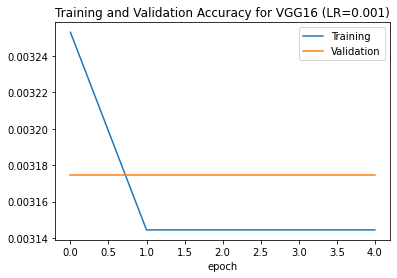

In [ ]:
print(history_VGG1.history.keys())
acc=history_VGG1.history['accuracy']
val_acc=history_VGG1.history['val_accuracy']
loss=history_VGG1.history['loss']
val_loss=history_VGG1.history['val_loss']
 
epochs=range(len(acc)) 
 
#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(history_VGG1.history['accuracy'])
plt.plot(history_VGG1.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Accuracy for VGG16 (LR=0.001)')
plt.xlabel('epoch')
plt.savefig("Training and Validation Accuracy (VGG16, LR =0.001).svg")

Plot Training and Validation Loss for VGG16

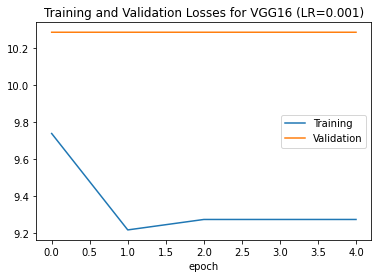

In [ ]:
# Plot graph between training and validation loss
plt.plot(history_VGG1.history['loss'])
plt.plot(history_VGG1.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Losses for VGG16 (LR=0.001)')
plt.xlabel('epoch')
plt.savefig("Training and Validation loss (VGG16, LR =0.001).svg")

### Testing VGG16 Model
**Epochs: 10 ,  Batch size: 64,  Learning Rate: 0.001,  Optimizer: ADAM**

In [ ]:
score = model.evaluate(test_generator)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

50/50 [==============================] - 7s 136ms/step - loss: 10.2849 - accuracy: 0.0032
Test Loss =  10.284880638122559
Test Accuracy =  0.0031746032182127237


Confusion Matrix

In [ ]:
# # Making prediction
# y_pred = model.predict(test_generator) #1575,315
# y_true = np.argmax(y_pred, axis=0) #315
# y_pred = np.argmax(y_pred, axis=0) #315
# print(y_true.shape)
# print(y_pred.shape)

# from sklearn.metrics import confusion_matrix
# confusion_mtx = confusion_matrix(y_true, y_pred)
# plt.confusion_mtx

y_pred = model.predict(test_generator)
y_true = np.argmax(y_pred, axis=0)
print(y_true.shape)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, np.argmax(y_pred, axis=0))


(315,)


array([[315]])

Display Model's Prediction

Original Class: 9
Predicted Class:  [279]


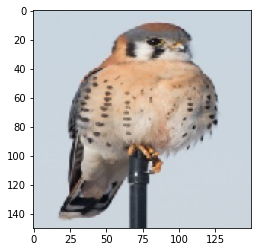

In [ ]:
from keras.preprocessing import image
img = image.load_img("/content/valid/AMERICAN KESTREL/2.jpg",target_size=(150,150))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
print("Original Class: 9")
output = model.predict(img)
print("Predicted Class: ", +np.argmax(output, axis=1 ))


### Training VGG16 Model
**Epochs: 10 ,  Batch size: 64,  Learning Rate: 0.1,  Optimizer: ADAM**

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam,
              metrics=['accuracy'])
start_time = time.time()
history_VGG2 = model.fit(train_generator, batch_size=64,
              epochs=10, 
              validation_data=validation_generator)
print("--- %s seconds ---" % (time.time() - start_time))

1153/1153 [==============================] - 480s 415ms/step - loss: 5.8249 - accuracy: 0.0045 - val_loss: 5.8409 - val_accuracy: 0.0032
--- 503.3859622478485 seconds ---


Plot Training and Validation Accuracy for VGG16

In [1]:
# print(history_VGG2.history.keys())
# acc=history_VGG2.history['accuracy']
# val_acc=history_VGG2.history['val_accuracy']
# loss=history_VGG2.history['loss']
# val_loss=history_VGG2.history['val_loss']
 
# epochs=range(len(acc)) 
 
# #Plot training and validation accuracy per epoch
# import matplotlib.pyplot as plt
# plt.plot(history_VGG2.history['accuracy'])
# plt.plot(history_VGG2.history['val_accuracy'])
# plt.legend(['Training', 'Validation'])
# plt.title('Training and Validation Accuracy')
# plt.xlabel('epoch')

Plot Training and Validation Loss for VGG16

In [2]:
# # Plot graph between training and validation loss
# plt.plot(history_VGG2.history['loss'])
# plt.plot(history_VGG2.history['val_loss'])
# plt.legend(['Training', 'Validation'])
# plt.title('Training and Validation Losses')
# plt.xlabel('epoch')

### Testing VGG16 Model
**Epochs: 10 ,  Batch size: 64,  Learning Rate: 0.1,  Optimizer: ADAM**

In [ ]:
score = model.evaluate(test_generator)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

In [ ]:
# import numpy as np
# import sklearn.metrics as metrics
# from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# # test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
# # predictions = model.predict(test_generator, steps=test_steps_per_epoch)

# pred = model.predict(test_generator, steps=1)

# # Get most likely class
# predicted_classes = np.argmax(pred[0])

# # true_classes = test_generator.classes
# # class_labels = list(test_generator.class_indices.keys())  
# # print(predictions[0][0])
# print(predicted_classes)

0


In [3]:
# print(decode_predictions(pred)[0])

In [ ]:
# save the model to disk
import joblib
filename = 'finalized_model.sav'
joblib.dump(model, filename)

# CUSTOM MODEL

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
model2 = Sequential()
model2.add(Conv2D(32, (5,5), padding='same', activation='relu',
                input_shape=(150, 150, 3)))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(64, (5,5), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(315, activation='softmax'))
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 64)        0

### Training Custom Model
**Epochs: 10 ,  Batch size: 64,  Learning Rate: 0.001,  Optimizer: ADAM**

In [11]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
import time
start_time = time.time()
history_custom1 = model2.fit(train_generator, batch_size=158,
              epochs=2, 
              validation_data=validation_generator)
print("--- %s seconds ---" % (time.time() - start_time))


Epoch 1/2
1153/1153 [==============================] - 328s 284ms/step - loss: 5.1363 - accuracy: 0.0402 - val_loss: 4.5099 - val_accuracy: 0.0762
Epoch 2/2
1153/1153 [==============================] - 336s 291ms/step - loss: 4.3649 - accuracy: 0.1178 - val_loss: 3.9304 - val_accuracy: 0.1524
--- 710.0238008499146 seconds ---


Plot Training and Validation Accuracy for Custom Model

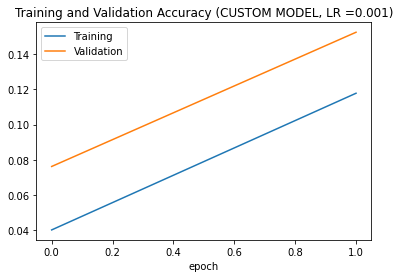

In [12]:
acc=history_custom1.history['accuracy']
val_acc=history_custom1.history['val_accuracy']
loss=history_custom1.history['loss']
val_loss=history_custom1.history['val_loss']
 
epochs=range(len(acc)) 
 
#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(history_custom1.history['accuracy'])
plt.plot(history_custom1.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Accuracy (CUSTOM MODEL, LR =0.001)')
plt.xlabel('epoch')
plt.savefig("Training and Validation Accuracy (CUSTOM MODEL, LR =0.001).svg")

Plot Training and Validation Loss for Custom Model

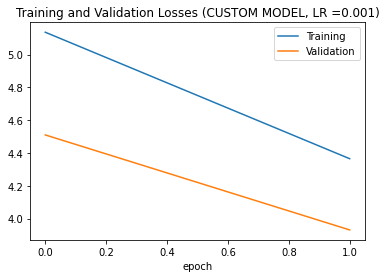

In [13]:
# Plot graph between training and validation loss
plt.plot(history_custom1.history['loss'])
plt.plot(history_custom1.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Losses (CUSTOM MODEL, LR =0.001)')
plt.xlabel('epoch')
plt.savefig("Training and Validation Loss (CUSTOM MODEL, LR =0.001).svg")

### Testing Custom Model
**Epochs: 10 ,  Batch size: 64,  Learning Rate: 0.001,  Optimizer: ADAM**

In [14]:
score = model2.evaluate(test_generator)
print(score)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

50/50 [==============================] - 4s 73ms/step - loss: 3.5906 - accuracy: 0.2394
[3.590643882751465, 0.2393650859594345]
Test Loss =  3.590643882751465
Test Accuracy =  0.2393650859594345


Confusion Matrix

In [15]:
# import seaborn as sns
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# # Predict the values from the validation dataset

# loss, accuracy = model2.evaluate(test_generator)
# print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))
# y_pred =  model.predict(test_generator)
# y_p = np.where(y_pred > 0.5, 1,0)
# test_data=test_generator.unbatch()
# y_g=[]
# for image, label in  test_data:
#   y_g.append(label.numpy())

# confusion_mtx = confusion_matrix(y_g, y_p) 
# # plot the confusion matrix
# f,ax = plt.subplots(figsize=(8, 8))
# sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix for custom model LR=0.001")
# plt.show()

In [16]:
# # import seaborn as sns
# # from sklearn.metrics import confusion_matrix
# # from sklearn.metrics import classification_report
# # # Predict the values from the validation dataset

# # # loss, accuracy = model2.evaluate(test_generator)
# # # print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))
# # # y_pred =  model2.predict(test_generator)
# # # y_p = np.argmax(y_pred, axis=1)
# # # test_data=test_generator
# # # y_g=[]
# # # for image, label in  test_data:
# # #   y_g.append(label)

# # # confusion_mtx = confusion_matrix(y_g, y_p) 
# # # # plot the confusion matrix
# # # f,ax = plt.subplots(figsize=(8, 8))
# # # sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
# # # plt.xlabel("Predicted Label")
# # # plt.ylabel("True Label")
# # # plt.title("Confusion Matrix")
# # # plt.show()

# # predictions = model.predict_generator(test_generator)
# # y_pred = np.argmax(predictions, axis=1)
# # print('Confusion Matrix')
# # cm = confusion_matrix(test_generator.classes, y_pred)

# # class_names = test_generator.class_indices

# # # Plot confusion matrix in a beautiful manner
# # fig = plt.figure(figsize=(16, 14))
# # ax= plt.subplot()
# # sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# # # labels, title and ticks
# # ax.set_xlabel('Predicted', fontsize=20)
# # ax.xaxis.set_label_position('bottom')
# # plt.xticks(rotation=90)
# # ax.xaxis.set_ticklabels(class_names, fontsize = 10)
# # ax.xaxis.tick_bottom()

# # ax.set_ylabel('True', fontsize=20)
# # ax.yaxis.set_ticklabels(class_names, fontsize = 10)
# # plt.yticks(rotation=0)

# # plt.title('Refined Confusion Matrix', fontsize=20)

# # plt.savefig('ConMat24.png')
# # plt.show()

# # augmented_images = [test_generator[0][0][0] for i in range(5)]
# # plt.plot(augmented_images)

# y_g=[]
# for image, label in  test_generator:
#   y_g.append(label)

# loss, accuracy = model2.evaluate_generator(test_generator)
# print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))
# Test: accuracy = 0.953125  ;  loss = 0.124623 

# vgg_y_pred =  model.predict_generator(test_generator)
# # vgg_y_p = np.where(vgg_y_pred > 0.5, 1,0)
# vgg_y_p = np.argmax(vgg_y_pred, axis=1)

# # compute the confusion matrix
# confusion_mtx = confusion_matrix(y_g, vgg_y_p) 
# # plot the confusion matrix
# f,ax = plt.subplots(figsize=(8, 8))
# sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()

Original Class: 302
Predicted Class:  [78]


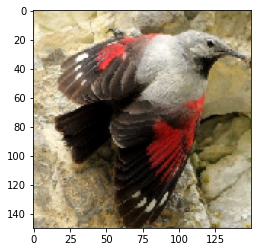

In [22]:
from keras.preprocessing import image
img = image.load_img("/content/valid/WALL CREAPER/2.jpg",target_size=(150,150))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

print("Original Class: 302")
output = model2.predict(img)
print("Predicted Class: ", +np.argmax(output, axis=1 ))

In [23]:
# Ddef plotimages(imagesls):
#   fig, axes = plt.subplots(1, 5, figsize=(20,20))
#   axes = axes.flatten()
#   for image,ax in zip(imagesls, axes):
#     ax.imshow(image)
#     ax.axis('off')


# augmented_images = [test_generator[0][0][0] for i in range(5)]
# plotimages(augmented_images)

# vgg_y_pred =  model.predict_generator(test_generator)
# # vgg_y_p = np.where(vgg_y_pred > 0.5, 1,0)
# vgg_y_p = np.argmax(vgg_y_pred, axis=1)
# print(vgg_y_p)


### Training Custom Model
**Epochs: 10 ,  Batch size: 64,  Learning Rate: 0.01,  Optimizer: ADAM**

In [24]:
# adam = tf.keras.optimizers.Adam(learning_rate=0.001)
# model2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
# start_time = time.time()
# history_custom2 = model2.fit(train_generator, batch_size=128,
#               epochs=10, 
#               validation_data=validation_generator)
# print("--- %s seconds ---" % (time.time() - start_time))

### Testing Custom Model
**Epochs: 10 ,  Batch size: 64,  Learning Rate: 0.1,  Optimizer: ADAM**

In [ ]:
# score = model2.evaluate(test_generator)
# print(score)
# print('Test Loss = ', score[0])
# print('Test Accuracy = ', score[1])

In [25]:
# # save the model to disk
# import joblib
# filename = 'finalized_model2.sav'
# joblib.dump(model2, filename)

Confusion Matrix

In [26]:
# import seaborn as sns
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# # Predict the values from the validation dataset

# loss, accuracy = model2.evaluate_generator(test_generator)
# print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))
# y_pred =  model.predict_generator(test_generator)
# y_p = np.where(y_pred > 0.5, 1,0)
# test_data=test_generator.unbatch()
# y_g=[]
# for image, label in  test_data:
#   y_g.append(label.numpy())

# confusion_mtx = confusion_matrix(y_g, y_p) 
# # plot the confusion matrix
# f,ax = plt.subplots(figsize=(8, 8))
# sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix for Custom Model ( LR= 0.1)")
# plt.show()

Training and Validation Accuracy for Custom Model

In [ ]:
# acc=history_custom2.history['accuracy']
# val_acc=history_custom2.history['val_accuracy']
# loss=history_custom2.history['loss']
# val_loss=history_custom2.history['val_loss']
 
# epochs=range(len(acc)) 
 
# #Plot training and validation accuracy per epoch
# import matplotlib.pyplot as plt
# plt.plot(history_custom2.history['accuracy'])
# plt.plot(history_custom2.history['val_accuracy'])
# plt.legend(['Training', 'Validation'])
# plt.title('Training and Validation Accuracy (CUSTOM MODEL, LR =0.1)')
# plt.xlabel('epoch')
# plt.savefig("Training and Validation Accuracy (CUSTOM MODEL, LR =0.1).svg")


Training and Validation Loss for Custom Model

In [ ]:

# # Plot graph between training and validation loss
# plt.plot(history_custom2.history['loss'])
# plt.plot(history_custom2.history['val_loss'])
# plt.legend(['Training', 'Validation'])
# plt.title('Training and Validation Losses (CUSTOM MODEL, LR =0.1)')
# plt.xlabel('epoch')
# plt.savefig("Training and Validation Loss (CUSTOM MODEL, LR =0.1).svg")

#**Grad-CAM**
https://keras.io/examples/vision/grad_cam/

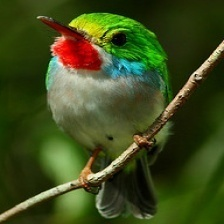

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

model_builder = model2
img_size = (150, 150)
preprocess_input = keras.applications.vgg16.preprocess_input
decode_predictions = keras.applications.vgg16.decode_predictions

last_conv_layer_name = "block5_conv3"

# The local path to our target image
img_path = "/content/test/CUBAN TODY/2.jpg"

display(Image(img_path))


def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [32]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# # Make model
# model = model_builder(weights="imagenet")

# Remove last layer's softmax
model2.layers[-1].activation = None

# Print what the top predicted class is
preds = model2.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model2, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

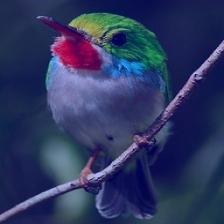

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)